In [ ]:
import sys
sys.path.append('/pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/')

import torch, random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from model import weight_init_xavier
from utils import mnist_data, set_seed, standardization

In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

# Start

## Standardize Data

In [ ]:
def standardization(x):
    mean = x.mean()
    std = x.std()
    x_new = (x - mean)/std
    return x_new

## Weight Initialization

In [ ]:
def weight_init_xavier(fan_in, fan_out, distribution = 'normal'):
    if distribution == 'normal':
        var = np.sqrt(2/(fan_in + fan_out))
        weight = np.random.normal(0, var, (fan_in, fan_out)).astype(np.float32)
    elif distribution == 'uniform':
        a = np.sqrt(6/(fan_in + fan_out))
        weight = np.random.uniform(-a, a, (fan_in, fan_out)).astype(np.float32)
    return weight

## Model

In [ ]:
class Linear_Layer:
    def __init__(self, input_dim, output_dim) -> None:
        self.weight = weight_init_xavier(input_dim, output_dim)
        self.bias = np.zeros((1, output_dim), dtype = np.float32)
    def forward(self, x):
        self.x = x
        self.out = self.x@self.weight + self.bias
        return self.out
    def backward(self, dz):
        dW = self.x.T@dz
        db = np.sum(dz, 0, keepdims = True)
        dX = dz@self.weight.T
        return dW, db, dX

class ReLU:
    def __init__(self) -> None:
        pass
    def forward(self, x):
        self.x = x
        x_out = np.maximum(0.0, self.x)
        return x_out
    def backward(self, grad_output):
        grad_input = grad_output * (self.x > 0).astype(np.float32)
        return grad_input

class Softmax:
    def __init__(self) -> None:
        pass
    def forward(self, x):
        x = np.atleast_2d(x)  # ensures 2D
        # subtract max for numerical stability
        shift = x - np.max(x, axis = 1, keepdims = True)
        exps = np.exp(shift)
        return exps/np.sum(exps, axis=1, keepdims = True)

class NLL:
    def __init__(self, eps=1e-12) -> None:
        self.eps = eps
        
    def forward(self, X, Y):
        # X: softmax probabilities, shape [N, C]
        self.X = X
        self.Y = Y
        N = self.X.shape[0]
        p = self.X[np.arange(N), self.Y]
        return -np.log(np.clip(p, self.eps, 1)).mean()
        
    def backward(self):
        # Returns dL/dZ (logits), using X=softmax(Z)
        N = self.X.shape[0]
        grad = self.X.copy()
        grad[np.arange(N), self.Y] -= 1
        grad /= N
        return grad        

In [ ]:
class MLP:
    def __init__(self, layer_dimensions, optim) -> None:

        self.hidden_layer1 = Linear_Layer(layer_dimensions[0], layer_dimensions[1])
        self.hidden_layer2 = Linear_Layer(layer_dimensions[1], layer_dimensions[2])
        self.final_layer = Linear_Layer(layer_dimensions[2], layer_dimensions[3])

        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.softmax = Softmax()
        self.optim = optim

    def step(self):
        self.optim.step(self.final_layer, self.dW3, self.db3)
        self.optim.step(self.hidden_layer2, self.dW2, self.db2)
        self.optim.step(self.hidden_layer1, self.dW1, self.db1)
        
    def forward(self, x):
        self.x = x.reshape(-1, 28*28).astype(np.float32)
        self.x_out_1 = self.relu1.forward(self.hidden_layer1.forward(self.x))
        self.x_out_2 = self.relu2.forward(self.hidden_layer2.forward(self.x_out_1))
        self.x_out_3 = self.final_layer.forward(self.x_out_2)
        out = self.softmax.forward(self.x_out_3)
        return out

    def backward(self, loss_back):
        
        self.dz3 = loss_back                                                # N x 10
        self.dW3, self.db3, da2 = self.final_layer.backward(self.dz3)       # 128 x 10, 1 x 10, N x 128
        self.dz2 = self.relu2.backward(da2)                                 # N x 128
        self.dW2, self.db2, da1 = self.hidden_layer2.backward(self.dz2)     # 256 x 128, 1 x 128, N x 256
        self.dz1 = self.relu1.backward(da1)                                 # N x 256
        self.dW1, self.db1, dX = self.hidden_layer1.backward(self.dz1)      # 784 x 256, 1 x 256


In [ ]:
class Optimizer:
    def __init__(self, otype = 'SGD', lr = 0.001, momentum1 = 0.9, momentum2 = 0.9, eps = 1e-8) -> None:
        self.lr = lr
        self.eps = eps
        self.otype = otype
        self.momentum1 = momentum1
        self.momentum2 = momentum2

    def _ensure_state(self, layer):
        # one velocity per parameter tensor, stored on the layer
        if not hasattr(layer, 'vW'):
            layer.vW = np.zeros_like(layer.weight)
        if not hasattr(layer, 'vb'):
            layer.vb = np.zeros_like(layer.bias)
            
        # for Adagrad & RMSProp & Adam one velocity per parameter tensor, stored on the layer
        if not hasattr(layer, 'gW'):
            layer.gW = np.zeros_like(layer.weight)
        if not hasattr(layer, 'gb'):
            layer.gb = np.zeros_like(layer.bias)
        if not hasattr(layer, 't'):
            layer.t  = 0
        
    def step(self, layer, dW, db):
        self._ensure_state(layer)
        
        if self.otype == 'SGD':
            layer.weight -= self.lr*dW
            layer.bias -= self.lr*db
        elif self.otype == 'Momentum_SGD':
            layer.vW = self.momentum1*layer.vW + dW
            layer.vb = self.momentum1*layer.vb + db
            layer.weight -= self.lr*layer.vW
            layer.bias -= self.lr*layer.vb
        elif self.otype == 'NAG':
            layer.vW = self.momentum1*layer.vW + dW
            layer.vb = self.momentum1*layer.vb + db
            layer.weight -= self.lr*(self.momentum1*layer.vW + dW)
            layer.bias -= self.lr*(self.momentum1*layer.vb + db)
        elif self.otype == 'Adagrad':
            layer.gW += dW**2
            layer.gb += db**2
            layer.weight -= self.lr*dW/(np.sqrt(layer.gW) + self.eps)
            layer.bias -= self.lr*db/(np.sqrt(layer.gb) + self.eps)
        elif self.otype == 'RMSProp':
            layer.gW = self.momentum2*layer.gW + (1 - self.momentum2)*dW**2
            layer.gb = self.momentum2*layer.gb + (1 - self.momentum2)*db**2
            layer.weight -= self.lr*dW/(np.sqrt(layer.gW) + self.eps)
            layer.bias -= self.lr*db/(np.sqrt(layer.gb) + self.eps)
        elif self.otype == 'Adam':
            layer.t += 1
            layer.vW = self.momentum1*layer.vW + (1 - self.momentum1)*dW
            layer.vb = self.momentum1*layer.vb + (1 - self.momentum1)*db
            layer.gW = self.momentum2*layer.gW + (1 - self.momentum2)*dW**2
            layer.gb = self.momentum2*layer.gb + (1 - self.momentum2)*db**2

            vW_hat = layer.vW/(1 - self.momentum1**layer.t)
            vb_hat = layer.vb/(1 - self.momentum1**layer.t)
            gW_hat = layer.gW/(1 - self.momentum2**layer.t)
            gb_hat = layer.gb/(1 - self.momentum2**layer.t)

            layer.weight -= self.lr*vW_hat/(np.sqrt(gW_hat) + self.eps)
            layer.bias -= self.lr*vb_hat/(np.sqrt(gb_hat) + self.eps)
        else:
            raise ValueError("Unknown optimizer")

def Accuracy(prob, target):
    return (prob == target).mean()

## Training

In [ ]:
train_data, test_data = mnist_data()

In [ ]:
## Train Data
images_train = []
labels_train = []
for i in tqdm(range(len(train_data))):
    images_train.append(np.array(train_data[i][0])/255.)
    labels_train.append(train_data[i][1])
images_train = np.stack(images_train)
labels_train = np.array(labels_train)
images_train_std = standardization(images_train.copy())

## Valid Data
images_valid = []
labels_valid = []
for i in tqdm(range(len(test_data))):
    images_valid.append(np.array(test_data[i][0])/255.)
    labels_valid.append(test_data[i][1])
images_valid = np.stack(images_valid)
labels_valid = np.array(labels_valid)
images_valid_std = standardization(images_valid.copy())

In [ ]:
batch_size = 64
epochs = 15
set_seed(batch_size)

layer_dimensions = [28*28, 256, 128, 10]

idx = 0
optimizers = ['SGD', 'Momentum_SGD', 'NAG', 'Adagrad', 'RMSProp', 'Adam']
lr_list = [0.01, 0.01, 0.01, 0.01, 0.001, 0.001]
momemt1 = [0.0, 0.9, 0.9, 0.0, 0.0, 0.9]
momemt2 = [0.0, 0.0, 0.0, 0.0, 0.9, 0.999]
model = MLP(layer_dimensions, optim)

categorical_loss = NLL()
optim = Optimizer(otype = optimizers[idx], lr =lr_list[idx], momentum1 = momemt1[idx], momentum2 = momemt2[idx])

log_softmax = torch.nn.LogSoftmax(dim=1)
loss_fn = torch.nn.NLLLoss()

In [ ]:
for epoch in range(epochs):
    print('*********************** Epoch: {} ****************************************'.format(epoch))
    loss_track = []
    pred_track = []
    gt_track = []
    n_batches = images_train_std.shape[0]//batch_size + 1
    for batch in tqdm(range(n_batches)):
        inp = images_train_std[batch_size*batch:min(batch_size*(batch+1), images_std.shape[0])]
        Y   = labels_train[batch_size*batch:min(batch_size*(batch+1), images_std.shape[0])]
        output = model.forward(inp)
        loss = categorical_loss.forward(output, Y)
        model.backward(categorical_loss.backward())
        model.step()
        loss_track.append(loss)
        pred_track.append(output.argmax(1))
        gt_track.append(Y)
    
    pred_track = np.hstack(pred_track)
    gt_track = np.hstack(gt_track)
    loss_track = np.hstack(loss_track)
    print('Train Loss, Accuracy: ', round(loss_track.mean(), 4), round(Accuracy(pred_track, gt_track), 4))

    loss_track = []
    pred_track = []
    gt_track = []
    n_batches = images_valid_std.shape[0]//batch_size + 1
    for batch in tqdm(range(n_batches)):
        inp = images_valid_std[batch_size*batch:min(batch_size*(batch+1), images_std.shape[0])]
        Y   = labels_valid[batch_size*batch:min(batch_size*(batch+1), images_std.shape[0])]
        output = model.forward(inp)
        loss = categorical_loss.forward(output, Y)
        loss_track.append(loss)
        pred_track.append(output.argmax(1))
        gt_track.append(Y)
    pred_track = np.hstack(pred_track)
    gt_track = np.hstack(gt_track)
    loss_track = np.hstack(loss_track)
    print('Valid Loss, Accuracy: ', round(loss_track.mean(), 4), round(Accuracy(pred_track, gt_track), 4))

In [1]:
import glob

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [29]:
folder_train = glob.glob('/pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/training*.png')
folder_test = glob.glob('/pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/metrics*.png')

In [30]:
def save_plots_line_by_line(img_paths, save_path='', dpi=180):
    """
    Load multiple PNG plots and save them stacked vertically in a single PNG.
    """
    n = len(img_paths)
    
    # figure height proportional to number of plots
    fig, axes = plt.subplots(n, 1, figsize=(12, 5*n))  
    
    if n == 1:
        axes = [axes]  # ensure iterable
    
    for ax, path in zip(axes, img_paths):
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(path.split('/')[-1], fontsize=9)  # show filename
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"✅ Combined image saved to {save_path} (dpi={dpi})")

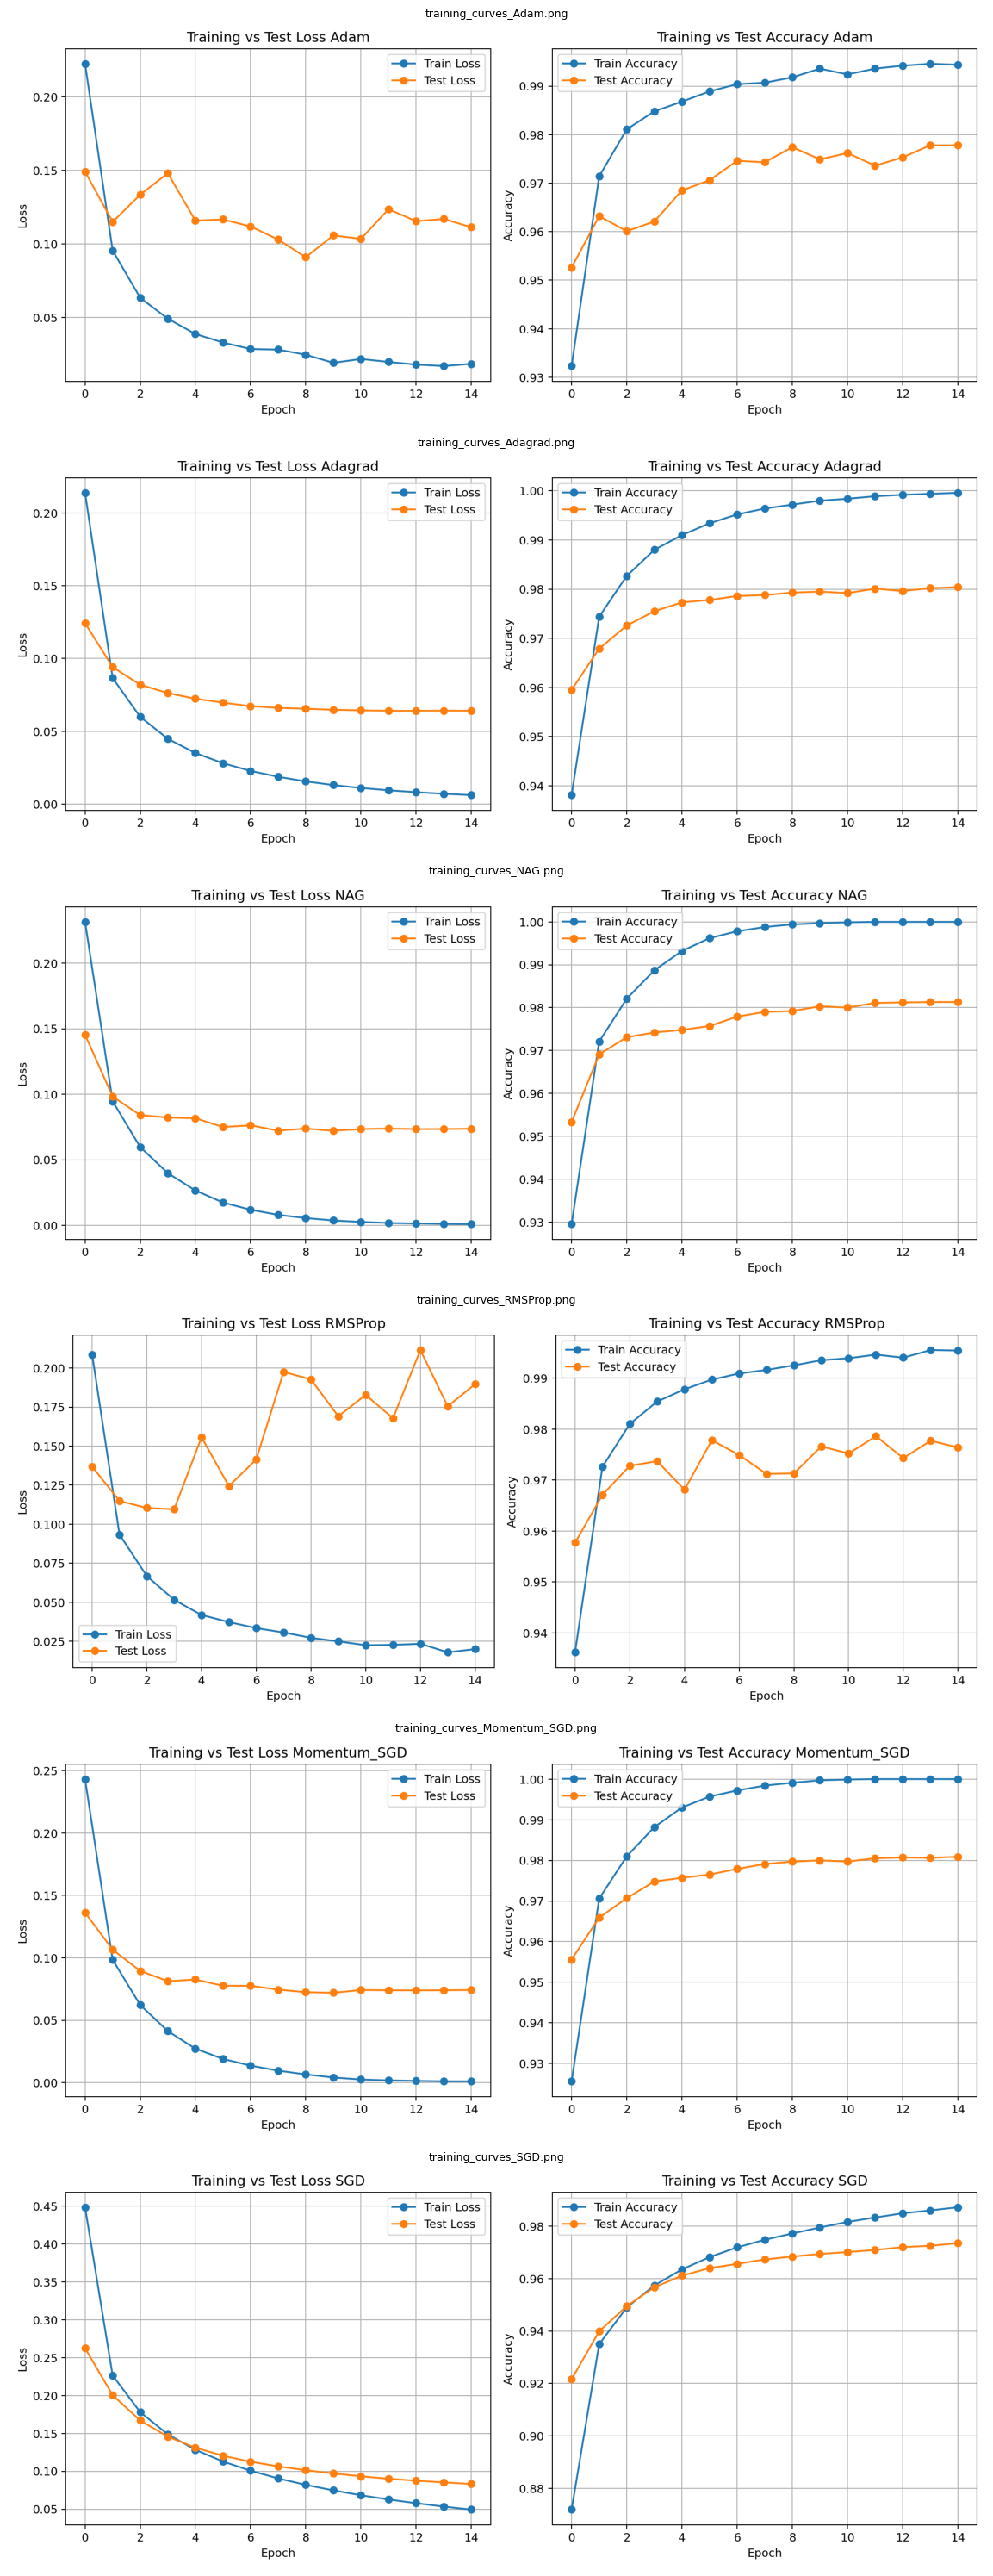

✅ Combined image saved to /pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/training_combined.png (dpi=180)


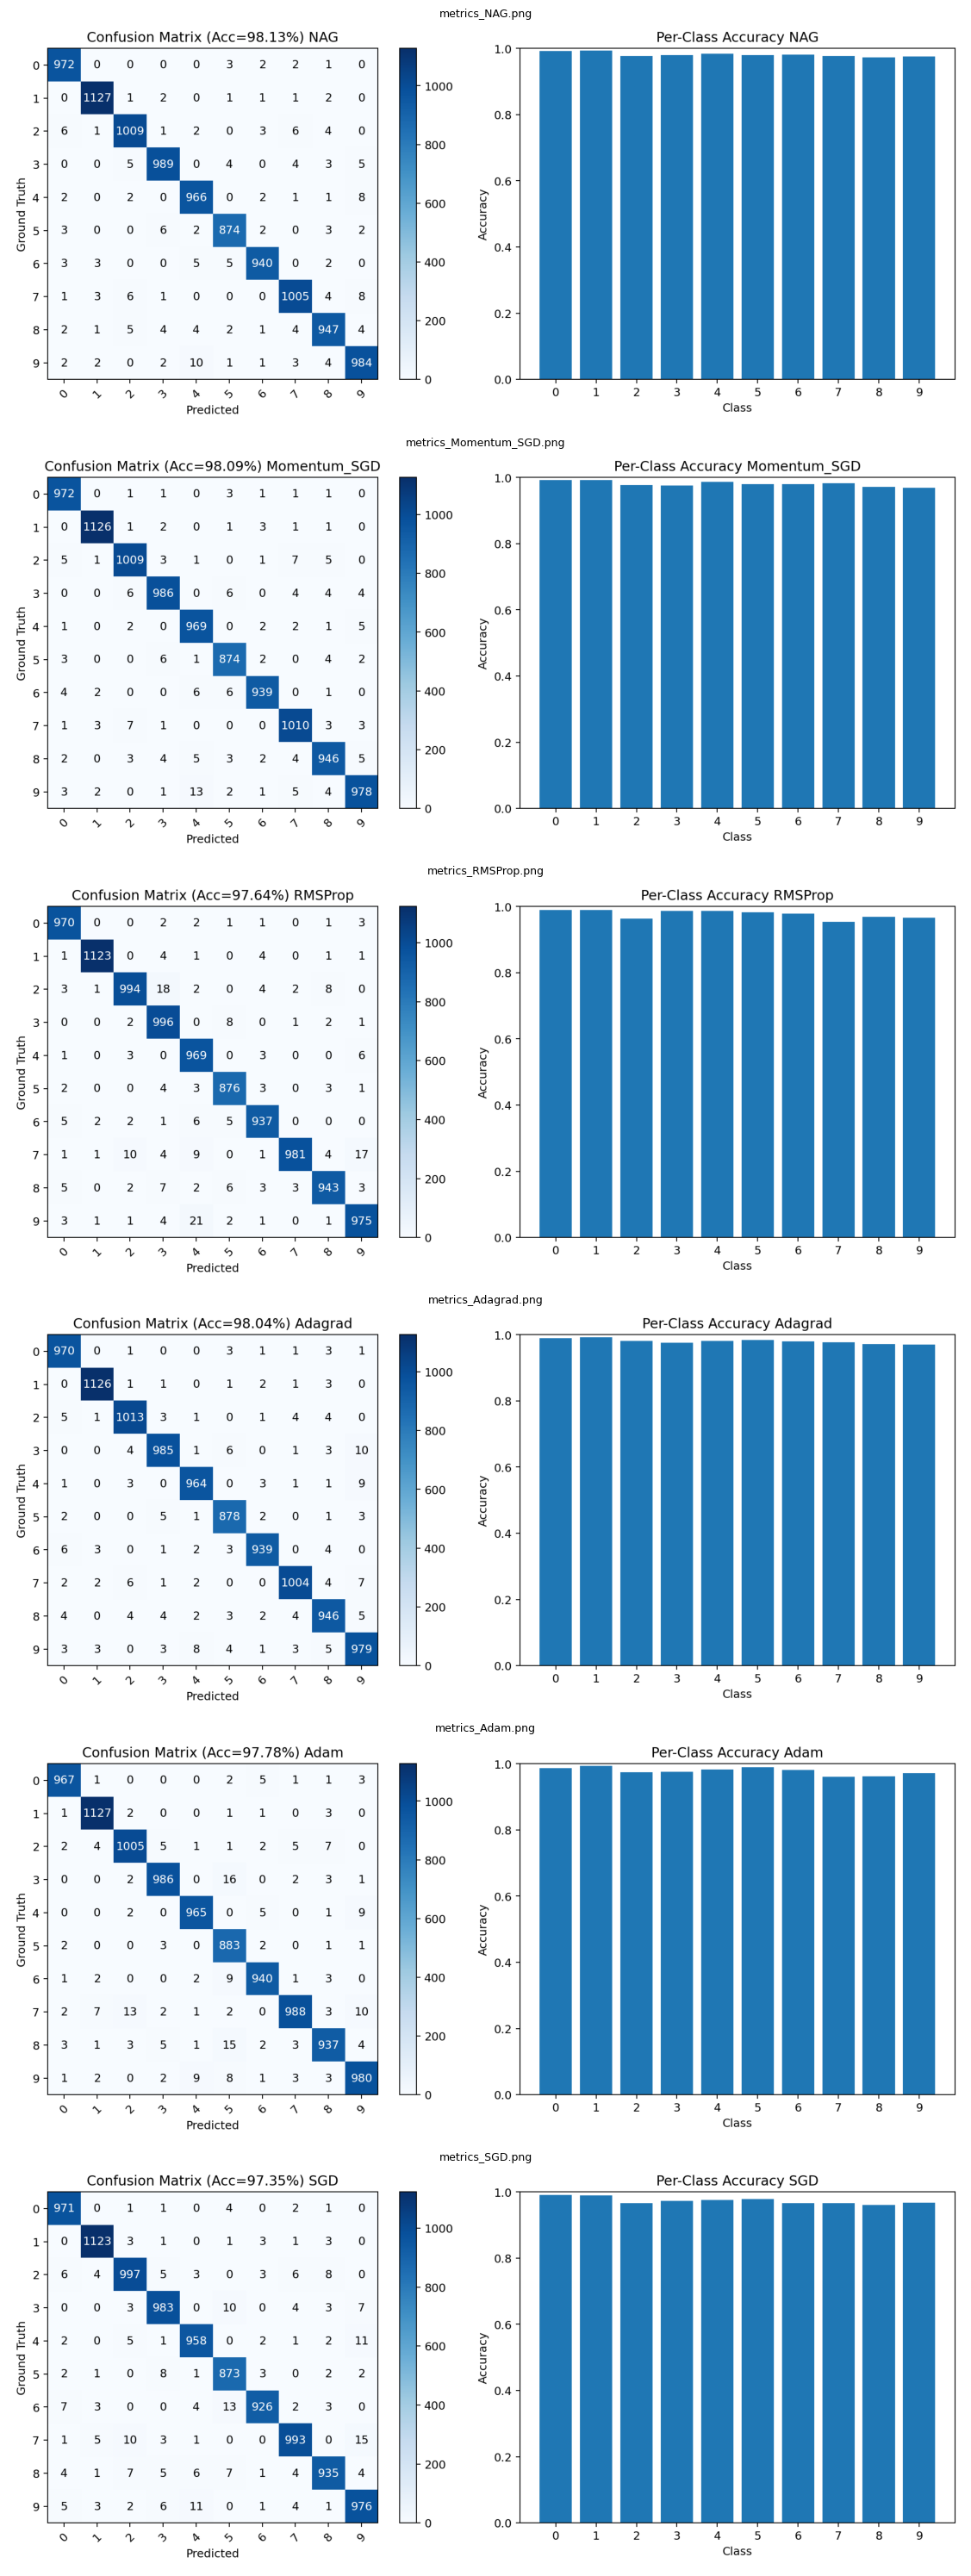

✅ Combined image saved to /pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/metrics_combined.png (dpi=180)


In [31]:
save_plots_line_by_line(folder_train, save_path = "/pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/training_combined.png")
save_plots_line_by_line(folder_test,  save_path = "/pfs/rdi/cei/home/acsingh/Research/Kaggle/Prep/Day_6/experiments/MLP_42_64/metrics_combined.png")